In [ ]:
pip install wordcloud

In [ ]:
pip install imgaug

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from numpy import array
import pandas as pd
from tqdm import tqdm
import datetime as datetime
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import glob
import string
import cv2
import random
import imgaug.augmenters as iaa
from pickle import dump, load
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import LSTM, Embedding, Dense, Activation, Dropout, Bidirectional, Flatten


In [ ]:
pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=5a6969f00ba998250eec3b758144996f7d8d0cdcb36e3366123482634d525589
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention
from keras.callbacks import ModelCheckpoint, ModelCheckpoint, TensorBoard


In [ ]:
from keras.layers import Concatenate
from keras.preprocessing import sequence
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
tf.random.set_seed(3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = '/content/drive/MyDrive/new/ICG/Flickr8k_Dataset/Flicker8k_Dataset/'
dir_Flickr_text = '/content/drive/MyDrive/new/ICG/Flickr8k_text/Flickr8k.token.txt'
images_lst = glob.glob(image_path + '*.jpg')
no_of_image = len(images_lst)
print(f'Total Images in Datset : {no_of_image}')

Total Images in Datset : 8091


In [ ]:
def load_txt(txt_file):
  with open(txt_file,'r') as file:
    text = file.read()
  return text


In [ ]:
def prepare_clean_txt(text):
  text_data = []
  table = str.maketrans('', '', string.punctuation)
  for line in tqdm(text.split('\n')):                          # spiltting over each line
    col = line.split('\t')                                     # splitting over each space in each line
    if len(col) == 1:                                          # neglecting data if full information not present
        continue
    filename, index = col[0].split("#")
    filename_path = image_path + filename                      # splitting to gather information about image index number and imageid
    txt = col[1].split()
    txt = [word.lower() for word in txt]                       # convert each word to lower case
    txt = [w.translate(table) for w in txt]                    # to remove punctuations from sentence
    txt = [word for word in txt if len(word)>1]                # to discard words of length 1
    txt = [word for word in txt if word.isalpha()]             # to discard numeric string
    txt = ' '.join(txt)
    text_data.append([index]+ [filename_path] + [txt])
  return text_data

In [ ]:
def prepare_dataframes(text_data):
  data_df = pd.DataFrame(text_data, columns=[ 'index', 'filename', 'caption'])
  data_df = data_df[data_df.filename != '2258277193_586949ec62.jpg.1']                              # removing data with improper imageid
  data_df['caption_with_tags'] = data_df['caption'].apply(lambda txt : 'startseq ' + txt + ' endseq')
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data_df.caption.values)
  data_df['caption_word_count'] = data_df['caption'].apply(lambda caption: len(caption.split()))
  word = []
  frequency = []
  for k,v in tokenizer.word_counts.items():
    word.append(k)
    frequency.append(v)
  df_word_count = pd.DataFrame({'word': word, 'frequency': frequency})
  df_word_count.sort_values('frequency', ascending=False, inplace=True, ignore_index=True)
  return data_df, df_word_count

In [ ]:
text = load_txt(dir_Flickr_text)
text_data = prepare_clean_txt(text)
data_df, df_word_count = prepare_dataframes(text_data)

100%|██████████| 40461/40461 [00:00<00:00, 48347.44it/s]


In [ ]:
data_df.head(3)

,index,filename,caption,caption_with_tags,caption_word_count
0,0,/content/drive/MyDrive/new/ICG/Flickr8k_Datase...,child in pink dress is climbing up set of stai...,startseq child in pink dress is climbing up se...,14
1,1,/content/drive/MyDrive/new/ICG/Flickr8k_Datase...,girl going into wooden building,startseq girl going into wooden building endseq,5
2,2,/content/drive/MyDrive/new/ICG/Flickr8k_Datase...,little girl climbing into wooden playhouse,startseq little girl climbing into wooden play...,6


In [ ]:
from collections import Counter
def utility_counter(data):
  filename = data_df.filename.values
  caption_count = Counter(filename).values()
  uni_filenames = np.unique(filename)
  print(f'Number of unique file names : {len(uni_filenames)}')
  print(f'Number of captions per image : {set(caption_count)}')
  print(f'All image have same number of captions: {all(caption_count)}')

utility_counter(data_df)

Number of unique file names : 8092
Number of captions per image : {5}
All image have same number of captions: True


In [ ]:
def image_caption_plotter(data):
  npic = 3
  target_size = (350, 500, 3)
  count = 1
  fig = plt.figure(figsize=(25, 22))
  for file in tqdm(random.sample(list(data['filename']), npic)):
    captions = list(data['caption'].loc[data['filename'] == file].values)
    image_load = load_img(file, target_size = target_size)
    ax = fig.add_subplot(npic, 2, count)
    ax.axis('off')
    ax.imshow(image_load, interpolation='nearest')
    count += 1
    ax = fig.add_subplot(npic, 2, count)
    ax.axis('off')
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
      ax.text(0, i, caption, fontsize = 30, fontfamily= 'fantasy', bbox=dict(facecolor='black', alpha=0.7), color='yellow')
    count += 1
    plt.grid(None)
  plt.show()

image_caption_plotter(data_df)

100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


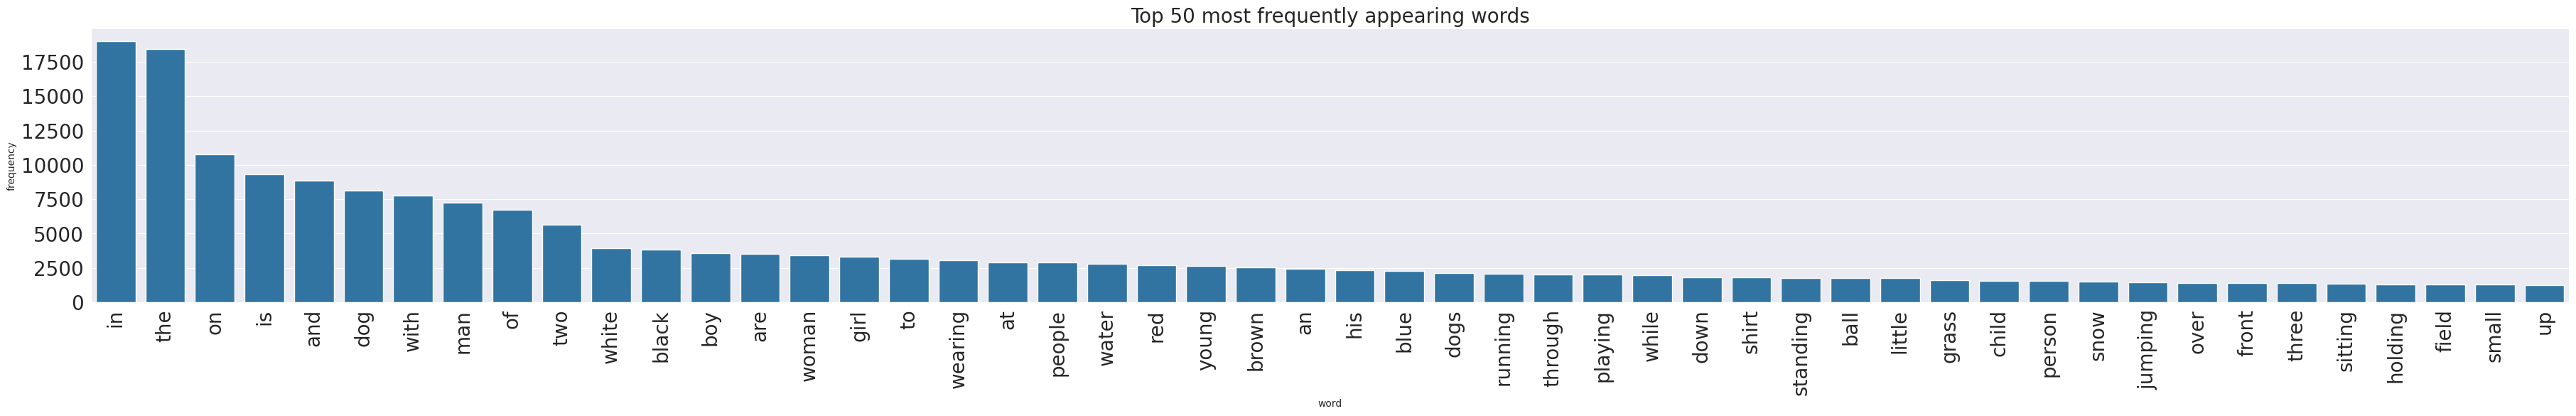

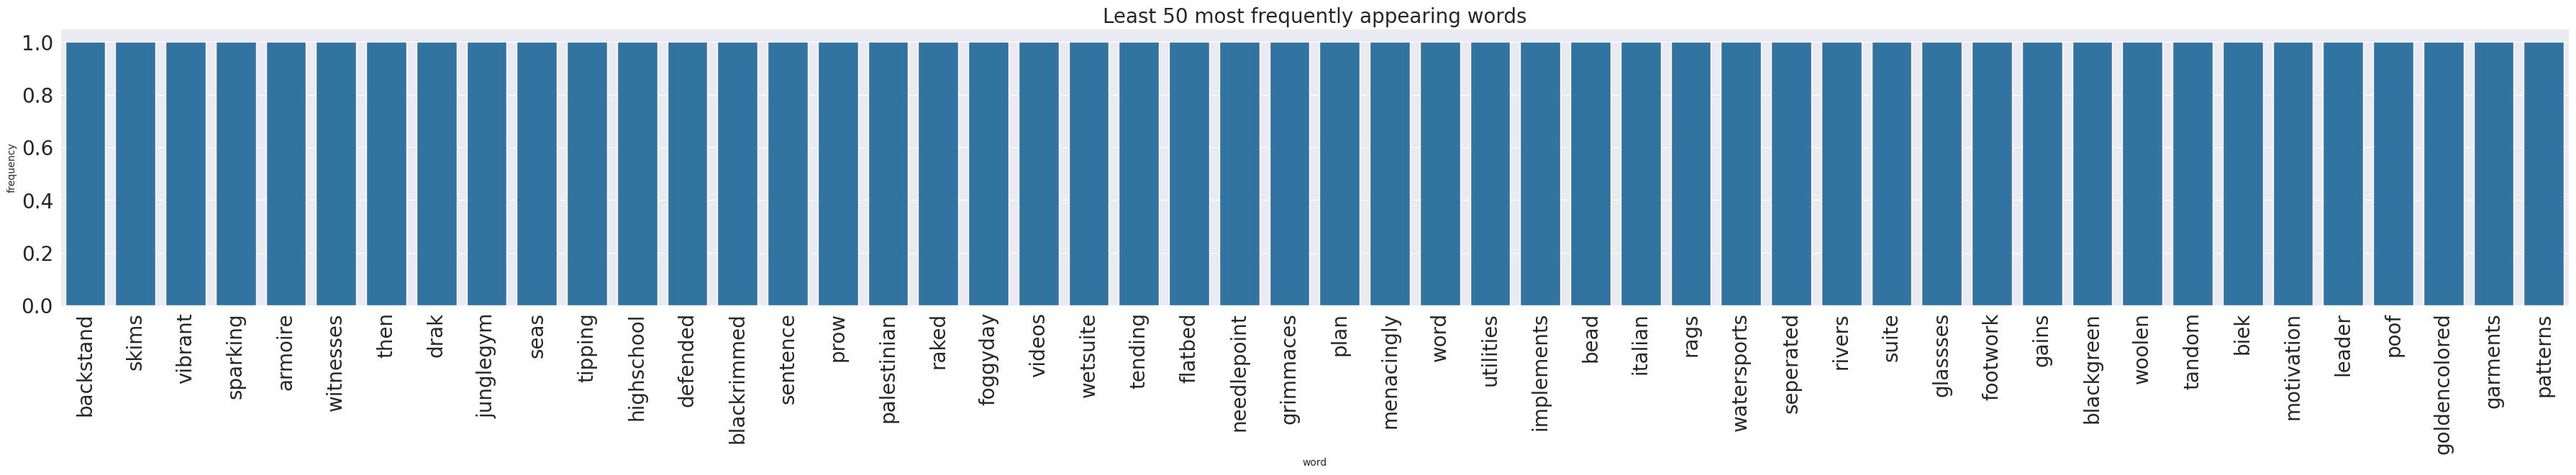

In [ ]:
count = 50

def plot_word_count(df, title = ''):
    sns.set_style('darkgrid')
    plt.figure(figsize = (45, 5))
    sns.barplot(x=df['word'], y=df["frequency"])
    plt.yticks(fontsize = 20)
    plt.xticks( rotation = 'vertical', fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.show()

plot_word_count(df_word_count.iloc[:count, :], title= 'Top 50 most frequently appearing words')
plot_word_count(df_word_count.iloc[-count:, :], title= 'Least 50 most frequently appearing words')

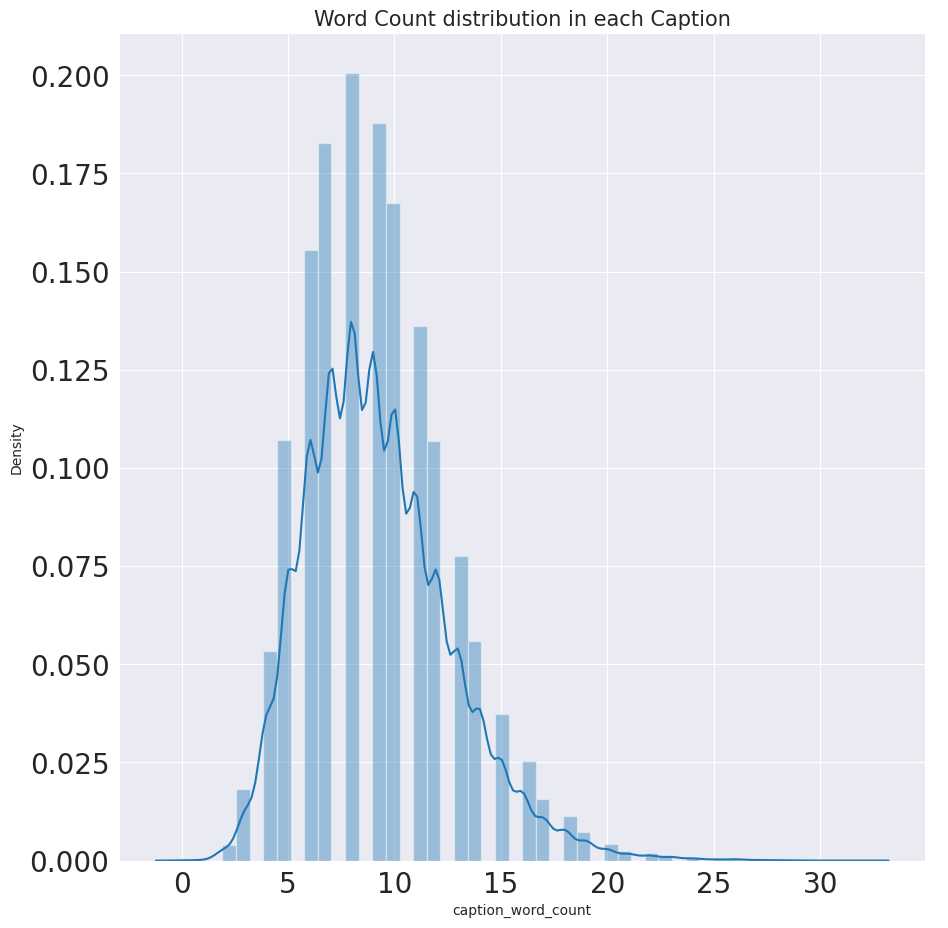

In [ ]:
sns.set_style('darkgrid')
sns.FacetGrid(data_df, height = 9).map(sns.distplot, 'caption_word_count').add_legend()
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.title('Word Count distribution in each Caption', fontsize = 15)
plt.show()

In [ ]:
train_images_file = '/content/drive/MyDrive/new/ICG/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
train_filename_container = [image_path+filename for filename in train_images if image_path+filename in images_lst]

validation_images_file = '/content/drive/MyDrive/new/ICG/Flickr8k_text/Flickr_8k.devImages.txt'
validation_images = set(open(validation_images_file, 'r').read().strip().split('\n'))
validation_filename_container = [image_path+filename for filename in validation_images if image_path+filename in images_lst]

train_filename_container = train_filename_container+validation_filename_container

test_images_file = '/content/drive/MyDrive/new/ICG/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_filename_container = [image_path+filename for filename in test_images if image_path+filename in images_lst]

In [ ]:

def augument_image(image_path, aug=True, visualize=False):
  if visualize:
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
  else:
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
  if aug:
    aug2 = iaa.Fliplr(1)
    aug3 = iaa.Flipud(1)
    aug4 = iaa.Emboss(alpha=(1), strength=1)
    aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
    aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

    a = np.random.uniform()
    if a<0.2:
      aug_image = aug2.augment_image(image)
    elif a<0.4:
      aug_image = aug3.augment_image(image)
    elif a<0.6:
      aug_image = aug4.augment_image(image)
    elif a<0.8:
      aug_image = aug5.augment_image(image)
    else:
      aug_image = aug6.augment_image(image)
    return image, aug_image
  else:
    return image

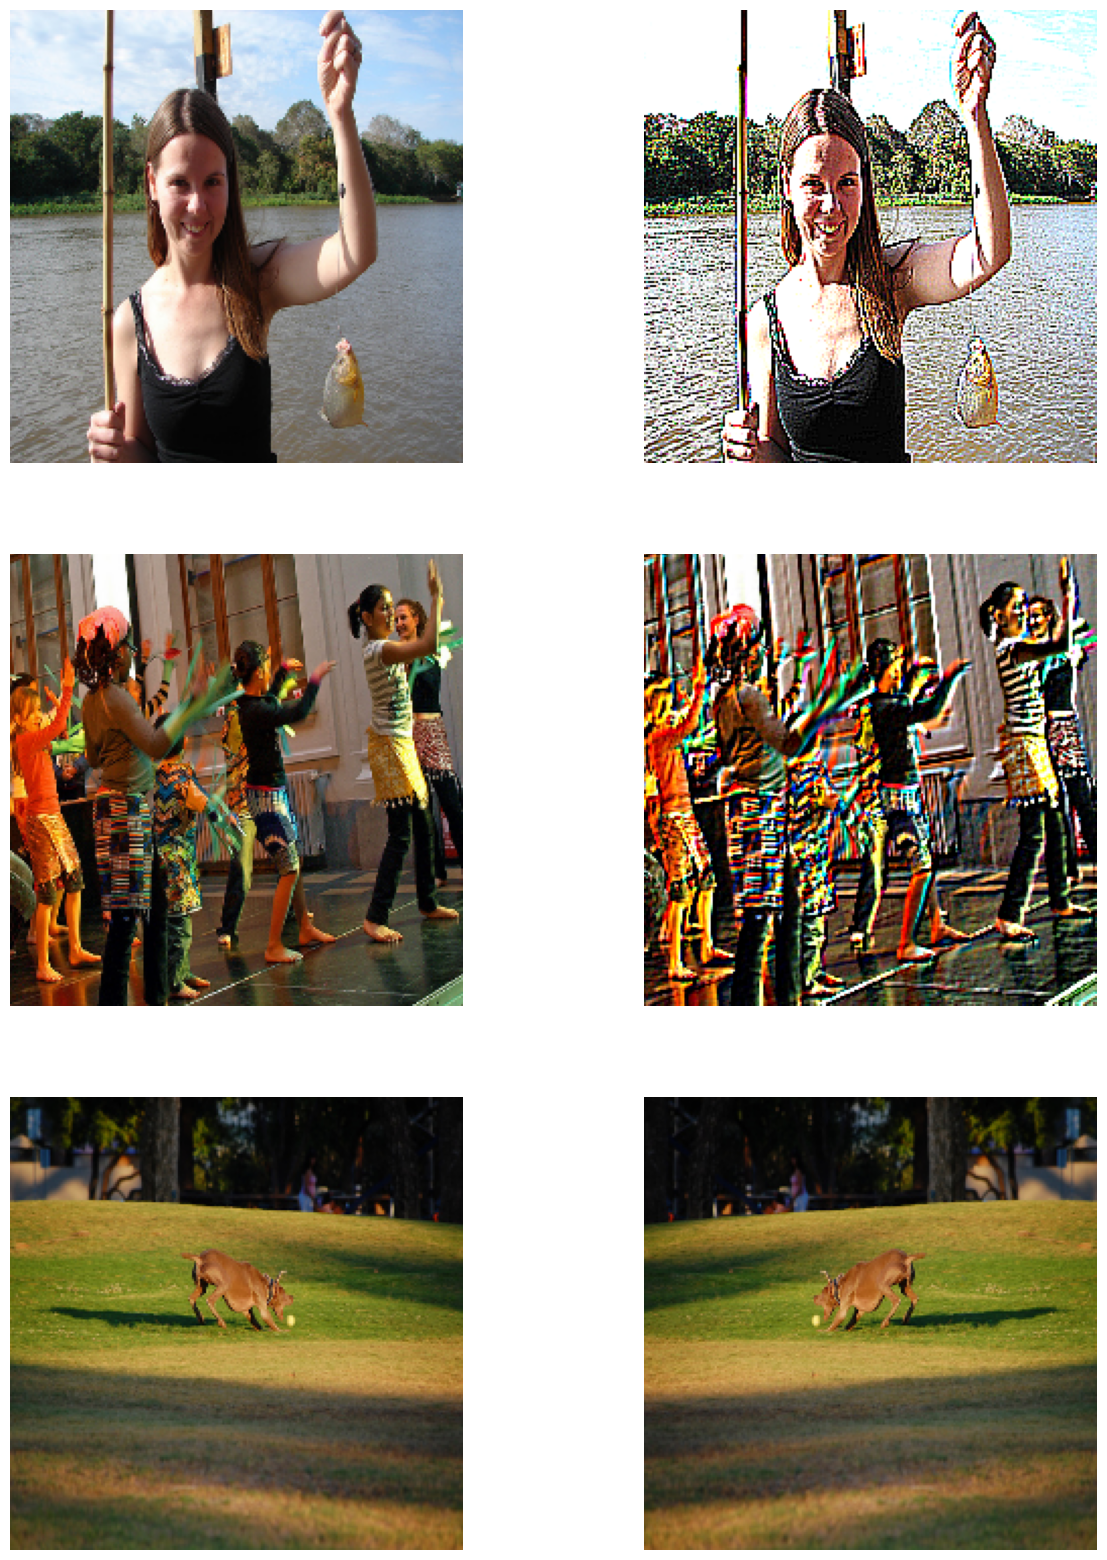

In [ ]:
row = 3
col = 2
dataset = [augument_image(train_filename_container[np.random.randint(0, 5000)], aug=True, visualize=True) for _ in range(0, 3)]
fig = plt.figure(figsize=(15, 20))
for counter in range(0, row*col):
  fig.add_subplot(row, col, counter+1)
  plt.imshow((dataset[int(counter/2)][counter%2]))
  plt.axis('off')
  plt.grid(None)

In [ ]:
train_caption_mapping = {}
for file in tqdm(train_filename_container):
    train_caption_mapping[file]= list(data_df.loc[data_df['filename'] == file].caption_with_tags)

test_caption_mapping = {}
for file in tqdm(test_filename_container):
    test_caption_mapping[file]= list(data_df.loc[data_df['filename'] == file].caption_with_tags)

In [ ]:
def encode_image(filename_container, aug=True):
  encoding = {}
  augmented_image_path = []
  for image_path in tqdm(filename_container):
    image = augument_image(image_path, aug=aug)
    if aug:
      image = preprocess_input(image[0])
      aug_image = preprocess_input(image[1])

      features = model_new(np.expand_dims(image, axis=0))
      features = np.reshape(features, (features.shape[1],))
      features_aug = model_new(np.expand_dims(image, axis=0))
      features_aug = np.reshape(features_aug, (features_aug.shape[1],))

      encoding[image_path] = features
      aug_path = image_path[:-4]+'_aug.jpg'
      augmented_image_path.append(aug_path)
      train_caption_mapping[aug_path] = train_caption_mapping[image_path]
      encoding[aug_path] = features_aug
    else:
      image = preprocess_input(image)
      features = model_new(np.expand_dims(image, axis=0))
      fearures = np.reshape(features, (features.shape[1],))
      encoding[image_path] = features
  global train_filename_container
  train_filename_container += augmented_image_path
  return encoding

In [ ]:
model_vgg16 = VGG16(weights='imagenet', include_top=True)
model_new = Model(model_vgg16.input, model_vgg16.layers[-2].output)

In [ ]:
encoding_train = encode_image(train_filename_container)
with open('/content/encoded_train_image_features.pkl', 'wb') as p:
    dump(encoding_train, p)


In [ ]:
encoding_test = encode_image(test_filename_container, aug=False)
with open('/content/encoded_test_image_feature.pkl', 'wb') as p:
    dump(encoding_test, p)

In [ ]:
train_features = load(open("/content/encoded_train_image_features.pkl", "rb"))
print('Number of train image features', len(train_features))

test_features = load(open("/content/encoded_test_image_feature.pkl", "rb"))
print('Number of test image features', len(test_features))

In [ ]:
all_train_captions = set()
for _, caption_lst in tqdm(train_caption_mapping.items()):
    for caption in caption_lst:
        all_train_captions.add(caption)

all_test_captions = set()
for _, caption_lst in tqdm(test_caption_mapping.items()):
    for caption in caption_lst:
        all_test_captions.add(caption)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from tqdm import tqdm

# Initialize the tokenizer and fit on all training captions
train_tokenizer = Tokenizer(oov_token='<UNK>')
train_tokenizer.fit_on_texts(all_train_captions)

# Convert all captions into sequences of word indices
train_sequences = train_tokenizer.texts_to_sequences(all_train_captions)

# Add padding to sequences (this is where you implement padding)
# padding='post' ensures padding is added to the end of the sequences
padded_train_sequences = pad_sequences(train_sequences, padding='post')

# If you need to check word frequencies as before, you can proceed with this part
words = []
frequency = []
for word, freq in tqdm(train_tokenizer.word_counts.items()):
    words.append(word)
    frequency.append(freq)

df_wc_train = pd.DataFrame({'word': words, 'frequency': frequency})
df_wc_train.sort_values('frequency', ascending=False, inplace=True, ignore_index=True)


In [ ]:
ixtoword = dict((index, word) for word, index in train_tokenizer.word_index.items())
wordtoix = train_tokenizer.word_index
max_length = max(map(lambda caption: len(caption.split()), all_train_captions))
vocab_size = len(wordtoix)+1

In [ ]:
def dataset_loader(tokenizer, image_caption_mapping, image_features, max_length, images_per_batch, vocab_size):
    image_feature, input_seq, output_seq = list(), list(), list()
    image_count=0
    while 1:
        for image_path, captions in image_caption_mapping.items():
            image_count+=1
            feature = image_features[image_path]
            sequences = tokenizer.texts_to_sequences(captions)
            for seq in sequences:
              for i in range(1, len(seq)):
                  in_seq, out_seq = seq[:i], seq[i]                                                       # split into input and output pair
                  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]                                  # pad input sequence
                  out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]           # encode output sequence
                  image_feature.append(feature)
                  input_seq.append(in_seq)
                  output_seq.append(out_seq)
            if image_count==images_per_batch:                                                             # yield the batch data
                yield (np.array(image_feature), np.array(input_seq)), np.array(output_seq)
                image_feature, input_seq, output_seq = list(), list(), list()
                image_count=0


In [ ]:
input_image = Input(shape=(4096, ), name='Image_Feature_input')
fe1 = Dropout(0.5, name='Dropout_image')(input_image)
fe2 = Dense(256, activation='relu', name='Activation_Encoder')(fe1)
input_text = Input(shape=(max_length,), name='Text_input')
se1 = Embedding(vocab_size, 500, mask_zero=True, name='Text_Feature')(input_text)
se2 = Dropout(0.5, name='Dropout_text')(se1)
se3 = LSTM(512, name='LSTM', return_sequences=True, use_cudnn=False)(se2)
se4 = SeqSelfAttention(attention_activation='sigmoid', name='Self-Attention')(se3)
se5 = Flatten()(se4)
se6 = Dense(256, activation='relu')(se5)
decoder1 = Concatenate(name='Concatenate')([fe2, se6])
decoder2 = Dense(256, activation='relu', name='Activation_Decoder')(decoder1)
output = Dense(vocab_size, activation='softmax',name='Output')(decoder2)
model = Model(inputs=[input_image, input_text], outputs=output)

In [ ]:
model.summary()


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
log_dir = "logs/fit/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir = log_dir, histogram_freq=1)

In [ ]:
number_pics_per_bath = 16
steps = len(train_caption_mapping)//number_pics_per_bath
learning_rate = 0.001



In [ ]:
train_generator = dataset_loader(train_tokenizer, train_caption_mapping, train_features, max_length, number_pics_per_bath, vocab_size)


In [ ]:
history = model.fit(train_generator, epochs=10, steps_per_epoch=steps, verbose=1, callbacks = [checkpoint, tensorboard])


In [ ]:
# Continue training for an additional 25 epochs
total_epochs = 10 + 5  # 10 already trained + 25 additional
history = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=10,  # Start from the 10th epoch
    steps_per_epoch=steps,
    verbose=1,
    callbacks=[checkpoint, tensorboard]
)


In [ ]:
# Continue training for an additional 25 epochs
total_epochs = 20  # 10 already trained + 25 additional
history = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=15,  # Start from the 10th epoch
    steps_per_epoch=steps,
    verbose=1,
    callbacks=[checkpoint, tensorboard]
)


In [ ]:
# Continue training for an additional 25 epochs
total_epochs = 25  # 10 already trained + 25 additional
history = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=20,  # Start from the 10th epoch
    steps_per_epoch=steps,
    verbose=1,
    callbacks=[checkpoint, tensorboard]
)


In [ ]:

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Model - Loss/Accuracy', fontsize=20)
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')

In [ ]:
model.save('image_caption_generator_model.h5')  # Save the trained model

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
with open("/content/encoded_test_image_feature.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def greedySearch(image):
    image = encoding_test[image]
    image = np.reshape(image, (1,4096))
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[word] for word in in_text.split()]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat].lower()
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import random
from keras.utils import load_img
from tqdm import tqdm

def image_caption_score_extractor(data):
    npic = 6
    target_size = (224, 224, 3)
    count = 1
    fig = plt.figure(figsize=(60, 65))

    for file in tqdm(random.sample(test_filename_container, npic)):
        predicted_caption = greedySearch(file)
        captions = list(data['caption'].loc[data['filename'] == file].values)
        image_load = load_img(file, target_size=target_size)

        # Plot image
        ax = fig.add_subplot(npic, 2, count)
        ax.axis('off')
        ax.imshow(image_load, interpolation='nearest')

        # Process captions and calculate BLEU score
        reference = [caption.lower().split() for caption in captions]  # Lowercase for uniformity
        candidate = predicted_caption.lower().split()                  # Lowercase for uniformity

        # Using smoothing to avoid harsh scores for short sentences
        score = round(sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method4), 3)

        # Plot reference captions and predicted caption with BLEU score
        count += 1
        ax = fig.add_subplot(npic, 2, count)
        ax.axis('off')
        ax.set_ylim(0, len(captions) + 2)

        for i, caption in enumerate(captions):
            ax.text(0, i, caption, fontsize=40, bbox=dict(facecolor='blue', alpha=0.1), color='red')

        ax.text(0, i+1, greedySearch(file), fontsize=40)
        ax.text(0, i+2, f'BLEU Score: {score}', fontsize=40, fontfamily='fantasy', bbox=dict(facecolor='white', alpha=0.7), color='blue')

        count += 1

    plt.grid(None)
    plt.show()

# Example usage
image_caption_score_extractor(data_df)
